# Run First Models

In [1]:
import pathlib
import sys
import pickle

from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno

%matplotlib inline

# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1
# add the 'src' directory to path to import modules
src_dir = pathlib.Path().cwd().resolve().parent / 'src'
#src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(str(src_dir))
# import my class code from the source
# %aimport src-dir.filename
from data.data_process import transform_ts_to_supervised

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
import keras

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.set_printoptions(suppress=True)

PROJECT_DIR = pathlib.Path.cwd().resolve().parent
CONSOL_DATA_DIR = PROJECT_DIR / 'data' / '07-consolidated'

Using TensorFlow backend.


In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
fp = CONSOL_DATA_DIR / 'epl.csv'
df = pd.read_csv(fp, index_col=None)

In [4]:
df.head()

,nation,league,season,date,h,a,h_ftGoals,a_ftGoals,h_corners,h_fouls,h_redCards,h_shots,h_shotsOnTarget,h_htGoals,h_yellowCards,a_corners,a_fouls,a_redCards,a_shots,a_shotsOnTarget,a_htGoals,a_yellowCards,h_oddsWinMean,h_oddsDrawMean,a_oddsWinMean,oddsHwinBet,oddsDrawBet,oddsAwinBet,oddsHwinPinn,oddsDrawPinn,oddsAwinPinn,oddsHwinMax,oddsDrawMax,oddsAwinMax,result,h_result,a_result,h_goalsFor,h_goalsAgainst,a_goalsFor,a_goalsAgainst,h_impliedWinProbMean,h_impliedDrawProbMean,a_impliedDrawProbMean,a_impliedWinProbMean,a_oddsDrawMean,h_h_ftGoals-0,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,h_h_ftGoals-6,h_h_ftGoals-7,h_h_ftGoals-8,h_h_ftGoals-9,h_h_ftGoals-10,h_h_ftGoals-11,h_h_ftGoals-12,h_h_ftGoals-13,h_h_ftGoals-14,h_h_ftGoals-15,h_h_ftGoals-16,h_h_ftGoals-17,h_h_ftGoals-18,a_a_ftGoals-0,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_a_ftGoals-7,a_a_ftGoals-8,a_a_ftGoals-9,a_a_ftGoals-10,a_a_ftGoals-11,a_a_ftGoals-12,a_a_ftGoals-13,a_a_ftGoals-14,a_a_ftGoals-15,a_a_ftGoals-16,a_a_ftGoals-17,a_a_ftGoals-18,a_h_ftGoals-1,a_h_ftGoals-10,a_h_ftGoals-11,a_h_ftGoals-12,a_h_ftGoals-13,a_h_ftGoals-14,a_h_ftGoals-15,a_h_ftGoals-16,a_h_ftGoals-17,a_h_ftGoals-18,a_h_ftGoals-19,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,a_h_ftGoals-7,a_h_ftGoals-8,a_h_ftGoals-9,h_a_ftGoals-1,h_a_ftGoals-10,h_a_ftGoals-11,h_a_ftGoals-12,h_a_ftGoals-13,h_a_ftGoals-14,h_a_ftGoals-15,h_a_ftGoals-16,h_a_ftGoals-17,h_a_ftGoals-18,h_a_ftGoals-19,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_a_ftGoals-7,h_a_ftGoals-8,h_a_ftGoals-9,h_h_shots-0,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,h_h_shots-6,h_h_shots-7,h_h_shots-8,h_h_shots-9,h_h_shots-10,h_h_shots-11,h_h_shots-12,h_h_shots-13,h_h_shots-14,h_h_shots-15,h_h_shots-16,h_h_shots-17,h_h_shots-18,a_a_shots-0,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_a_shots-7,a_a_shots-8,a_a_shots-9,a_a_shots-10,a_a_shots-11,a_a_shots-12,a_a_shots-13,a_a_shots-14,a_a_shots-15,a_a_shots-16,a_a_shots-17,a_a_shots-18,a_h_shots-1,a_h_shots-10,a_h_shots-11,a_h_shots-12,a_h_shots-13,a_h_shots-14,a_h_shots-15,a_h_shots-16,a_h_shots-17,a_h_shots-18,a_h_shots-19,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,a_h_shots-7,a_h_shots-8,a_h_shots-9,h_a_shots-1,h_a_shots-10,h_a_shots-11,h_a_shots-12,h_a_shots-13,h_a_shots-14,h_a_shots-15,h_a_shots-16,h_a_shots-17,h_a_shots-18,h_a_shots-19,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_a_shots-7,h_a_shots-8,h_a_shots-9,h_h_shotsOnTarget-0,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,h_h_shotsOnTarget-6,h_h_shotsOnTarget-7,h_h_shotsOnTarget-8,h_h_shotsOnTarget-9,h_h_shotsOnTarget-10,h_h_shotsOnTarget-11,h_h_shotsOnTarget-12,h_h_shotsOnTarget-13,h_h_shotsOnTarget-14,h_h_shotsOnTarget-15,h_h_shotsOnTarget-16,h_h_shotsOnTarget-17,h_h_shotsOnTarget-18,a_a_shotsOnTarget-0,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_a_shotsOnTarget-7,a_a_shotsOnTarget-8,a_a_shotsOnTarget-9,a_a_shotsOnTarget-10,a_a_shotsOnTarget-11,a_a_shotsOnTarget-12,a_a_shotsOnTarget-13,a_a_shotsOnTarget-14,a_a_shotsOnTarget-15,a_a_shotsOnTarget-16,a_a_shotsOnTarget-17,a_a_shotsOnTarget-18,a_h_shotsOnTarget-1,a_h_shotsOnTarget-10,a_h_shotsOnTarget-11,a_h_shotsOnTarget-12,a_h_shotsOnTarget-13,a_h_shotsOnTarget-14,a_h_shotsOnTarget-15,a_h_shotsOnTarget-16,a_h_shotsOnTarget-17,a_h_shotsOnTarget-18,a_h_shotsOnTarget-19,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,a_h_shotsOnTarget-7,a_h_shotsOnTarget-8,a_h_shotsOnTarget-9,h_a_shotsOnTarget-1,h_a_shotsOnTarget-10,h_a_shotsOnTarget-11,h_a_shotsOnTarget-12,h_a_shotsOnTarget-13,h_a_shotsOnTarget-14,h_a_shotsOnTarget-15,h_a_shotsOnTarget-16,h_a_shotsOnTarget-17,h_a_shotsOnTarget-18,h_a_shotsOnTarget-19,h_a_shotsOnTa

In [5]:
import re

def get_n_past_games(df_orig, past_games=2, dropna_rows=True):
    """
    Restrict historical records to the last n games
    If n = 2, then will get
    home team
        last 2 games played at home ie. h_h_feature-1, h_h_feature-2
        last 2 games played away ie h_a_feature-1, h_a_feature-2
    away team
        last 2 games played at home ie a_h_feature-1, a_h_feature-2
        last 2 games played away ie a_a_feature-1, a_a_feature-2
    where -1 is the most recent game prior to the current game, and -2 is the game before that
    the current games result is in result
    """
    df = df_orig.copy(deep=True)
    keeper_cols1 = [col for col in df.columns if '-' in col]
    keeper_cols2 = [col for col in keeper_cols1 if int(col.split('-')[-1]) <= past_games]
    keeper_cols3 = [col for col in keeper_cols2 if int(col.split('-')[-1]) > 0]

    keeper_cols4 = keeper_cols3 + ['result', 'h_ftGoals', 'a_ftGoals']
    

    df = df[keeper_cols4]
    return keeper_cols3, df

PAST_GAMES = 6

keeper_cols3, df_cut = get_n_past_games(df, PAST_GAMES)

df_cut.head()

,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,h_h_ftGoals-6,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_h_ftGoals-1,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,h_a_ftGoals-1,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,h_h_shots-6,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_h_shots-1,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,h_a_shots-1,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,h_h_shotsOnTarget-6,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_h_shotsOnTarget-1,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,h_a_shotsOnTarget-1,h_a_shotsOnTarget-2,h_a_shotsOnTarget-3,h_a_shotsOnTarget-4,h_a_shotsOnTarget-5,h_a_shotsOnTarget-6,h_h_oddsWinMean-1,h_h_oddsWinMean-2,h_h_oddsWinMean-3,h_h_oddsWinMean-4,h_h_oddsWinMean-5,h_h_oddsWinMean-6,a_a_oddsWinMean-1,a_a_oddsWinMean-2,a_a_oddsWinMean-3,a_a_oddsWinMean-4,a_a_oddsWinMean-5,a_a_oddsWinMean-6,a_h_oddsWinMean-1,a_h_oddsWinMean-2,a_h_oddsWinMean-3,a_h_oddsWinMean-4,a_h_oddsWinMean-5,a_h_oddsWinMean-6,h_a_oddsWinMean-1,h_a_oddsWinMean-2,h_a_oddsWinMean-3,h_a_oddsWinMean-4,h_a_oddsWinMean-5,h_a_oddsWinMean-6,h_h_oddsDrawMean-1,h_h_oddsDrawMean-2,h_h_oddsDrawMean-3,h_h_oddsDrawMean-4,h_h_oddsDrawMean-5,h_h_oddsDrawMean-6,a_a_oddsDrawMean-1,a_a_oddsDrawMean-2,a_a_oddsDrawMean-3,a_a_oddsDrawMean-4,a_a_oddsDrawMean-5,a_a_oddsDrawMean-6,a_h_oddsDrawMean-1,a_h_oddsDrawMean-2,a_h_oddsDrawMean-3,a_h_oddsDrawMean-4,a_h_oddsDrawMean-5,a_h_oddsDrawMean-6,h_a_oddsDrawMean-1,h_a_oddsDrawMean-2,h_a_oddsDrawMean-3,h_a_oddsDrawMean-4,h_a_oddsDrawMean-5,h_a_oddsDrawMean-6,result,h_ftGoals,a_ftGoals
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,awin,1.0,2.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,awin,1.0,3.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,draw,2.0,2.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hwin,2.0,1.0


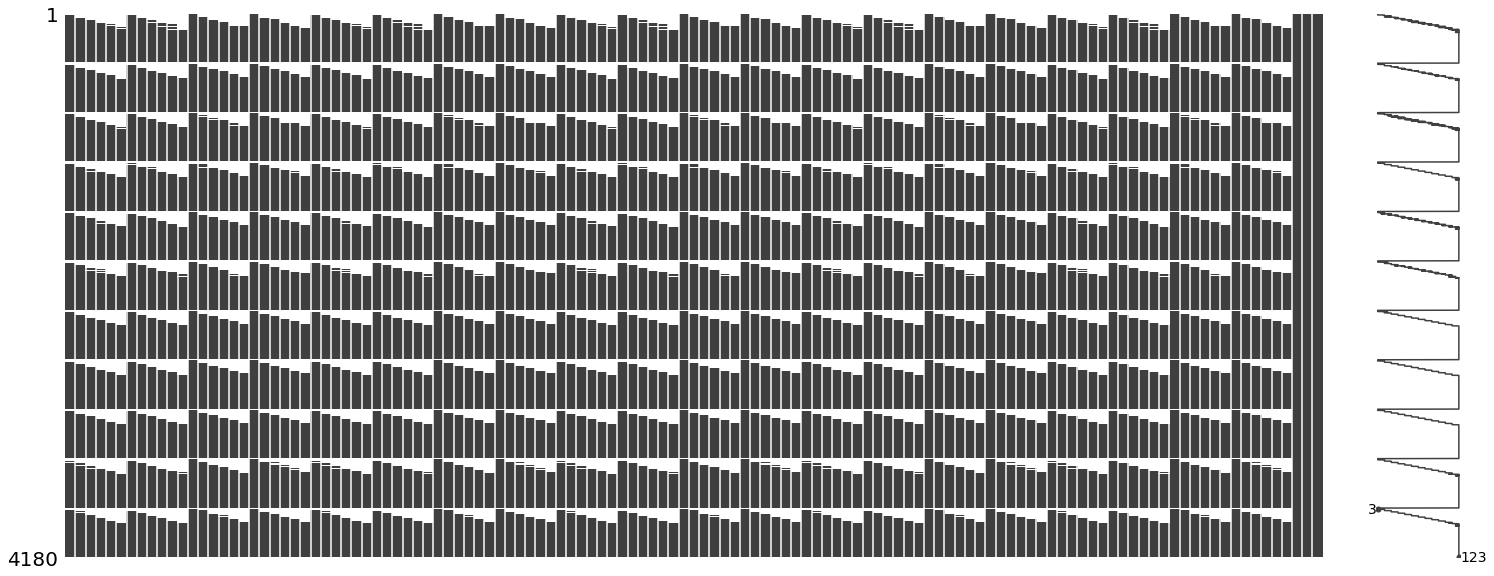

In [6]:
msno.matrix(df_cut)

plt.show();

In [7]:
df_cut.tail()

,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,h_h_ftGoals-6,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_h_ftGoals-1,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,h_a_ftGoals-1,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,h_h_shots-6,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_h_shots-1,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,h_a_shots-1,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,h_h_shotsOnTarget-6,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_h_shotsOnTarget-1,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,h_a_shotsOnTarget-1,h_a_shotsOnTarget-2,h_a_shotsOnTarget-3,h_a_shotsOnTarget-4,h_a_shotsOnTarget-5,h_a_shotsOnTarget-6,h_h_oddsWinMean-1,h_h_oddsWinMean-2,h_h_oddsWinMean-3,h_h_oddsWinMean-4,h_h_oddsWinMean-5,h_h_oddsWinMean-6,a_a_oddsWinMean-1,a_a_oddsWinMean-2,a_a_oddsWinMean-3,a_a_oddsWinMean-4,a_a_oddsWinMean-5,a_a_oddsWinMean-6,a_h_oddsWinMean-1,a_h_oddsWinMean-2,a_h_oddsWinMean-3,a_h_oddsWinMean-4,a_h_oddsWinMean-5,a_h_oddsWinMean-6,h_a_oddsWinMean-1,h_a_oddsWinMean-2,h_a_oddsWinMean-3,h_a_oddsWinMean-4,h_a_oddsWinMean-5,h_a_oddsWinMean-6,h_h_oddsDrawMean-1,h_h_oddsDrawMean-2,h_h_oddsDrawMean-3,h_h_oddsDrawMean-4,h_h_oddsDrawMean-5,h_h_oddsDrawMean-6,a_a_oddsDrawMean-1,a_a_oddsDrawMean-2,a_a_oddsDrawMean-3,a_a_oddsDrawMean-4,a_a_oddsDrawMean-5,a_a_oddsDrawMean-6,a_h_oddsDrawMean-1,a_h_oddsDrawMean-2,a_h_oddsDrawMean-3,a_h_oddsDrawMean-4,a_h_oddsDrawMean-5,a_h_oddsDrawMean-6,h_a_oddsDrawMean-1,h_a_oddsDrawMean-2,h_a_oddsDrawMean-3,h_a_oddsDrawMean-4,h_a_oddsDrawMean-5,h_a_oddsDrawMean-6,result,h_ftGoals,a_ftGoals
4175,0.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,0.0,1.0,0.0,2.0,0.0,2.0,17.0,8.0,18.0,7.0,10.0,14.0,11.0,16.0,17.0,3.0,14.0,7.0,22.0,12.0,23.0,14.0,27.0,20.0,14.0,9.0,9.0,8.0,7.0,15.0,2.0,4.0,3.0,5.0,3.0,4.0,3.0,5.0,5.0,0.0,7.0,3.0,5.0,4.0,6.0,4.0,11.0,8.0,3.0,1.0,2.0,4.0,2.0,4.0,1.86,3.24,1.75,2.74,5.56,2.17,1.50,1.90,1.86,5.63,3.38,1.61,1.18,2.23,1.27,2.36,1.30,1.37,15.42,3.14,3.32,4.13,13.84,3.63,3.47,3.54,3.52,3.12,3.80,3.13,4.23,3.44,3.61,4.14,3.24,3.96,7.37,3.51,5.83,3.29,5.54,4.89,7.57,3.29,3.25,3.45,6.95,3.42,hwin,3.0,0.0
4176,2.0,2.0,0.0,0.0,1.0,1.0,4.0,3.0,3.0,2.0,3.0,1.0,3.0,0.0,5.0,2.0,1.0,5.0,1.0,1.0,0.0,2.0,0.0,0.0,14.0,10.0,18.0,6.0,18.0,10.0,19.0,17.0,18.0,17.0,9.0,20.0,19.0,15.0,19.0,20.0,13.0,19.0,13.0,11.0,6.0,15.0,9.0,6.0,6.0,7.0,6.0,4.0,3.0,4.0,7.0,6.0,4.0,6.0,5.0,7.0,7.0,2.0,12.0,6.0,3.0,11.0,8.0,5.0,2.0,8.0,0.0,2.0,1.71,4.37,1.74,4.42,1.75,5.37,1.32,2.63,1.35,1.23,1.78,1.28,1.13,1.09,1.13,1.88,1.60,1.21,2.50,2.58,3.08,5.86,2.62,2.79,3.90,3.61,3.67,3.80,3.43,3.94,5.44,3.52,5.12,6.47,3.95,5.69,9.25,11.57,8.89,3.69,4.14,6.76,3.20,3.24,3.40,4.32,3.19,3.12,awin,0.0,1.0
4177,0.0,0.0,1.0,4.0,1.0,3.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,11.0,10.0,17.0,9.0,12.0,12.0,5.0,11.0,8.0,12.0,6.0,13.0,7.0,8.0,10.0,9.0,3.0,15.0,12.0,4.0,7.0,3.0,0.0,11.0,3.0,3.0,7.0,8.0,4.0,4.0,1.0,7.0,2.0,3.0,2.0,4.0,2.0,3.0,4.0,4.0,0.0,3.0,3.0,1.0,1.0,2.0,0.0,1.0,3.04,6.97,2.53,2.55,2.45,6.93,9.73,3.91,9.57,5.16,5.13,4.12,2.65,2.28,9.98,2.45,13.18,2.19,3.54,21.51,3.29,13.32,3.16,4.03,3.20,4.23,3.15,3.17,2.98,4.37,5.54,3.41,5.64,3.67,3.76,3.58,3.31,3.20,5.28,3.23,6.47,3.18,3.50,8.89,3.15,6.09,3.08,3.13,awin,1.0,2.0
4178,0.0,3.0,5.0,2.0,4.0,2.0,1.0,0.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0,4.0,0.0,2.0,0.0,2.0,1.0,2.0,20.0,20.0,13.0,14.0,21.0,9.0,6.0,9.0,12.0,10.0,14.0,9.0,11.0,8.0,13.0,15.0,13.0,16.0,10.0,9.0,10.0,16.0,14.0,16.0,2.0,7.0,10.0,3.0,12.0,3.0,3.0,1.0,3.0,4.0,6.0,2.0,4.0,5.0,4.0,3.0,6.0,5

In [8]:
df_cut2 = df_cut.dropna(subset=keeper_cols3).reset_index(drop=True)
df_cut2.drop(columns=['h_ftGoals', 'a_ftGoals'], inplace=True)
df_cut2.head()

,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,h_h_ftGoals-6,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_h_ftGoals-1,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,h_a_ftGoals-1,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,h_h_shots-6,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_h_shots-1,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,h_a_shots-1,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,h_h_shotsOnTarget-6,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_h_shotsOnTarget-1,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,h_a_shotsOnTarget-1,h_a_shotsOnTarget-2,h_a_shotsOnTarget-3,h_a_shotsOnTarget-4,h_a_shotsOnTarget-5,h_a_shotsOnTarget-6,h_h_oddsWinMean-1,h_h_oddsWinMean-2,h_h_oddsWinMean-3,h_h_oddsWinMean-4,h_h_oddsWinMean-5,h_h_oddsWinMean-6,a_a_oddsWinMean-1,a_a_oddsWinMean-2,a_a_oddsWinMean-3,a_a_oddsWinMean-4,a_a_oddsWinMean-5,a_a_oddsWinMean-6,a_h_oddsWinMean-1,a_h_oddsWinMean-2,a_h_oddsWinMean-3,a_h_oddsWinMean-4,a_h_oddsWinMean-5,a_h_oddsWinMean-6,h_a_oddsWinMean-1,h_a_oddsWinMean-2,h_a_oddsWinMean-3,h_a_oddsWinMean-4,h_a_oddsWinMean-5,h_a_oddsWinMean-6,h_h_oddsDrawMean-1,h_h_oddsDrawMean-2,h_h_oddsDrawMean-3,h_h_oddsDrawMean-4,h_h_oddsDrawMean-5,h_h_oddsDrawMean-6,a_a_oddsDrawMean-1,a_a_oddsDrawMean-2,a_a_oddsDrawMean-3,a_a_oddsDrawMean-4,a_a_oddsDrawMean-5,a_a_oddsDrawMean-6,a_h_oddsDrawMean-1,a_h_oddsDrawMean-2,a_h_oddsDrawMean-3,a_h_oddsDrawMean-4,a_h_oddsDrawMean-5,a_h_oddsDrawMean-6,h_a_oddsDrawMean-1,h_a_oddsDrawMean-2,h_a_oddsDrawMean-3,h_a_oddsDrawMean-4,h_a_oddsDrawMean-5,h_a_oddsDrawMean-6,result
0,1.0,0.0,1.0,1.0,3.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,13.0,13.0,5.0,13.0,18.0,13.0,7.0,17.0,13.0,16.0,9.0,5.0,5.0,7.0,16.0,13.0,11.0,10.0,11.0,1.0,12.0,8.0,8.0,14.0,6.0,7.0,4.0,7.0,12.0,9.0,4.0,11.0,5.0,12.0,6.0,1.0,3.0,4.0,5.0,7.0,7.0,6.0,6.0,0.0,7.0,3.0,3.0,7.0,2.56,4.88,2.76,2.39,2.24,2.41,14.34,5.22,4.45,3.70,3.38,2.91,2.76,5.31,2.03,2.00,2.56,2.41,4.15,12.05,2.62,2.82,4.09,3.04,3.18,3.44,3.20,3.20,3.21,3.18,5.75,3.43,3.35,3.25,3.25,3.20,3.21,3.51,3.21,3.26,3.16,3.18,3.28,5.29,3.19,3.20,3.28,3.22,draw
1,0.0,1.0,0.0,1.0,1.0,3.0,2.0,4.0,1.0,1.0,0.0,1.0,2.0,4.0,4.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,15.0,13.0,13.0,5.0,13.0,18.0,10.0,21.0,11.0,16.0,15.0,20.0,22.0,18.0,17.0,17.0,17.0,14.0,11.0,1.0,12.0,8.0,8.0,14.0,7.0,6.0,7.0,4.0,7.0,12.0,4.0,13.0,4.0,8.0,6.0,12.0,15.0,14.0,12.0,9.0,9.0,5.0,6.0,0.0,7.0,3.0,3.0,7.0,2.07,2.56,4.88,2.76,2.39,2.24,2.86,1.76,1.51,1.80,1.88,1.61,1.34,1.19,1.17,2.00,1.20,1.51,4.15,12.05,2.62,2.82,4.09,3.04,3.24,3.18,3.44,3.20,3.20,3.21,3.13,3.37,3.74,3.34,3.25,3.51,4.40,5.75,6.05,3.17,5.69,3.77,3.28,5.29,3.19,3.20,3.28,3.22,hwin
2,0.0,0.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,0.0,0.0,1.0,1.0,6.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,5.0,10.0,10.0,16.0,12.0,13.0,9.0,15.0,4.0,20.0,6.0,15.0,16.0,16.0,16.0,18.0,19.0,8.0,13.0,7.0,4.0,8.0,4.0,2.0,2.0,6.0,3.0,8.0,5.0,7.0,6.0,8.0,1.0,8.0,2.0,10.0,9.0,4.0,8.0,7.0,11.0,2.0,9.0,0.0,3.0,3.0,2.0,3.15,3.26,2.57,4.09,2.38,2.85,1.41,1.64,1.70,3.70,1.66,2.88,1.34,1.49,1.31,1.37,1.28,1.19,7.80,4.93,4.85,16.55,14.68,7.33,3.22,3.19,3.19,3.31,3.18,3.19,4.05,3.51,3.44,3.17,3.43,3.06,4.37,3.77,4.67,4.23,4.74,5.74,4.01,3.43,3.39,6.12,5.90,3.91,awin
3,1.0,3.0,0.0,1.0,0.0,2.0,4.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,7.0,0.0,3.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,13.0,16.0,17.0,10.0,6.0,7.0,10.0,15.0,14.0,13.0,15.0,18.0,20.0,10.0,25.0,9.0,11.0,7.0,7.0,13.0,6.0,5.0,9.0,11.0,8.0,10.0,9.0,5.0,3.0,3.0,7.0,8.0,8.0,7.0,10.0,4.0,12.0,3.0,17.0,2.0,6.0,6.0,6.0,8.0,5.0,2.0,4.0,6.0,2.62,2.06,6.40,2.38,

In [9]:
df_cut2.tail()

,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,h_h_ftGoals-6,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_h_ftGoals-1,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,h_a_ftGoals-1,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,h_h_shots-6,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_h_shots-1,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,h_a_shots-1,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,h_h_shotsOnTarget-6,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_h_shotsOnTarget-1,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,h_a_shotsOnTarget-1,h_a_shotsOnTarget-2,h_a_shotsOnTarget-3,h_a_shotsOnTarget-4,h_a_shotsOnTarget-5,h_a_shotsOnTarget-6,h_h_oddsWinMean-1,h_h_oddsWinMean-2,h_h_oddsWinMean-3,h_h_oddsWinMean-4,h_h_oddsWinMean-5,h_h_oddsWinMean-6,a_a_oddsWinMean-1,a_a_oddsWinMean-2,a_a_oddsWinMean-3,a_a_oddsWinMean-4,a_a_oddsWinMean-5,a_a_oddsWinMean-6,a_h_oddsWinMean-1,a_h_oddsWinMean-2,a_h_oddsWinMean-3,a_h_oddsWinMean-4,a_h_oddsWinMean-5,a_h_oddsWinMean-6,h_a_oddsWinMean-1,h_a_oddsWinMean-2,h_a_oddsWinMean-3,h_a_oddsWinMean-4,h_a_oddsWinMean-5,h_a_oddsWinMean-6,h_h_oddsDrawMean-1,h_h_oddsDrawMean-2,h_h_oddsDrawMean-3,h_h_oddsDrawMean-4,h_h_oddsDrawMean-5,h_h_oddsDrawMean-6,a_a_oddsDrawMean-1,a_a_oddsDrawMean-2,a_a_oddsDrawMean-3,a_a_oddsDrawMean-4,a_a_oddsDrawMean-5,a_a_oddsDrawMean-6,a_h_oddsDrawMean-1,a_h_oddsDrawMean-2,a_h_oddsDrawMean-3,a_h_oddsDrawMean-4,a_h_oddsDrawMean-5,a_h_oddsDrawMean-6,h_a_oddsDrawMean-1,h_a_oddsDrawMean-2,h_a_oddsDrawMean-3,h_a_oddsDrawMean-4,h_a_oddsDrawMean-5,h_a_oddsDrawMean-6,result
2816,0.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,0.0,1.0,0.0,2.0,0.0,2.0,17.0,8.0,18.0,7.0,10.0,14.0,11.0,16.0,17.0,3.0,14.0,7.0,22.0,12.0,23.0,14.0,27.0,20.0,14.0,9.0,9.0,8.0,7.0,15.0,2.0,4.0,3.0,5.0,3.0,4.0,3.0,5.0,5.0,0.0,7.0,3.0,5.0,4.0,6.0,4.0,11.0,8.0,3.0,1.0,2.0,4.0,2.0,4.0,1.86,3.24,1.75,2.74,5.56,2.17,1.50,1.90,1.86,5.63,3.38,1.61,1.18,2.23,1.27,2.36,1.30,1.37,15.42,3.14,3.32,4.13,13.84,3.63,3.47,3.54,3.52,3.12,3.80,3.13,4.23,3.44,3.61,4.14,3.24,3.96,7.37,3.51,5.83,3.29,5.54,4.89,7.57,3.29,3.25,3.45,6.95,3.42,hwin
2817,2.0,2.0,0.0,0.0,1.0,1.0,4.0,3.0,3.0,2.0,3.0,1.0,3.0,0.0,5.0,2.0,1.0,5.0,1.0,1.0,0.0,2.0,0.0,0.0,14.0,10.0,18.0,6.0,18.0,10.0,19.0,17.0,18.0,17.0,9.0,20.0,19.0,15.0,19.0,20.0,13.0,19.0,13.0,11.0,6.0,15.0,9.0,6.0,6.0,7.0,6.0,4.0,3.0,4.0,7.0,6.0,4.0,6.0,5.0,7.0,7.0,2.0,12.0,6.0,3.0,11.0,8.0,5.0,2.0,8.0,0.0,2.0,1.71,4.37,1.74,4.42,1.75,5.37,1.32,2.63,1.35,1.23,1.78,1.28,1.13,1.09,1.13,1.88,1.60,1.21,2.50,2.58,3.08,5.86,2.62,2.79,3.90,3.61,3.67,3.80,3.43,3.94,5.44,3.52,5.12,6.47,3.95,5.69,9.25,11.57,8.89,3.69,4.14,6.76,3.20,3.24,3.40,4.32,3.19,3.12,awin
2818,0.0,0.0,1.0,4.0,1.0,3.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,11.0,10.0,17.0,9.0,12.0,12.0,5.0,11.0,8.0,12.0,6.0,13.0,7.0,8.0,10.0,9.0,3.0,15.0,12.0,4.0,7.0,3.0,0.0,11.0,3.0,3.0,7.0,8.0,4.0,4.0,1.0,7.0,2.0,3.0,2.0,4.0,2.0,3.0,4.0,4.0,0.0,3.0,3.0,1.0,1.0,2.0,0.0,1.0,3.04,6.97,2.53,2.55,2.45,6.93,9.73,3.91,9.57,5.16,5.13,4.12,2.65,2.28,9.98,2.45,13.18,2.19,3.54,21.51,3.29,13.32,3.16,4.03,3.20,4.23,3.15,3.17,2.98,4.37,5.54,3.41,5.64,3.67,3.76,3.58,3.31,3.20,5.28,3.23,6.47,3.18,3.50,8.89,3.15,6.09,3.08,3.13,awin
2819,0.0,3.0,5.0,2.0,4.0,2.0,1.0,0.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0,4.0,0.0,2.0,0.0,2.0,1.0,2.0,20.0,20.0,13.0,14.0,21.0,9.0,6.0,9.0,12.0,10.0,14.0,9.0,11.0,8.0,13.0,15.0,13.0,16.0,10.0,9.0,10.0,16.0,14.0,16.0,2.0,7.0,10.0,3.0,12.0,3.0,3.0,1.0,3.0,4.0,6.0,2.0,4.0,5.0,4.0,3.0,6.0,5.0,5.0,3.0,3.0,6.0,2.0,4.0,1.31,1.24,1.19,1.

In [10]:
#df_temp = df_cut2.iloc[:, -5:]
df_temp = df_cut2

In [11]:
df_temp.head()

,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,h_h_ftGoals-6,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_h_ftGoals-1,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,h_a_ftGoals-1,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,h_h_shots-6,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_h_shots-1,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,h_a_shots-1,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,h_h_shotsOnTarget-6,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_h_shotsOnTarget-1,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,h_a_shotsOnTarget-1,h_a_shotsOnTarget-2,h_a_shotsOnTarget-3,h_a_shotsOnTarget-4,h_a_shotsOnTarget-5,h_a_shotsOnTarget-6,h_h_oddsWinMean-1,h_h_oddsWinMean-2,h_h_oddsWinMean-3,h_h_oddsWinMean-4,h_h_oddsWinMean-5,h_h_oddsWinMean-6,a_a_oddsWinMean-1,a_a_oddsWinMean-2,a_a_oddsWinMean-3,a_a_oddsWinMean-4,a_a_oddsWinMean-5,a_a_oddsWinMean-6,a_h_oddsWinMean-1,a_h_oddsWinMean-2,a_h_oddsWinMean-3,a_h_oddsWinMean-4,a_h_oddsWinMean-5,a_h_oddsWinMean-6,h_a_oddsWinMean-1,h_a_oddsWinMean-2,h_a_oddsWinMean-3,h_a_oddsWinMean-4,h_a_oddsWinMean-5,h_a_oddsWinMean-6,h_h_oddsDrawMean-1,h_h_oddsDrawMean-2,h_h_oddsDrawMean-3,h_h_oddsDrawMean-4,h_h_oddsDrawMean-5,h_h_oddsDrawMean-6,a_a_oddsDrawMean-1,a_a_oddsDrawMean-2,a_a_oddsDrawMean-3,a_a_oddsDrawMean-4,a_a_oddsDrawMean-5,a_a_oddsDrawMean-6,a_h_oddsDrawMean-1,a_h_oddsDrawMean-2,a_h_oddsDrawMean-3,a_h_oddsDrawMean-4,a_h_oddsDrawMean-5,a_h_oddsDrawMean-6,h_a_oddsDrawMean-1,h_a_oddsDrawMean-2,h_a_oddsDrawMean-3,h_a_oddsDrawMean-4,h_a_oddsDrawMean-5,h_a_oddsDrawMean-6,result
0,1.0,0.0,1.0,1.0,3.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,13.0,13.0,5.0,13.0,18.0,13.0,7.0,17.0,13.0,16.0,9.0,5.0,5.0,7.0,16.0,13.0,11.0,10.0,11.0,1.0,12.0,8.0,8.0,14.0,6.0,7.0,4.0,7.0,12.0,9.0,4.0,11.0,5.0,12.0,6.0,1.0,3.0,4.0,5.0,7.0,7.0,6.0,6.0,0.0,7.0,3.0,3.0,7.0,2.56,4.88,2.76,2.39,2.24,2.41,14.34,5.22,4.45,3.70,3.38,2.91,2.76,5.31,2.03,2.00,2.56,2.41,4.15,12.05,2.62,2.82,4.09,3.04,3.18,3.44,3.20,3.20,3.21,3.18,5.75,3.43,3.35,3.25,3.25,3.20,3.21,3.51,3.21,3.26,3.16,3.18,3.28,5.29,3.19,3.20,3.28,3.22,draw
1,0.0,1.0,0.0,1.0,1.0,3.0,2.0,4.0,1.0,1.0,0.0,1.0,2.0,4.0,4.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,15.0,13.0,13.0,5.0,13.0,18.0,10.0,21.0,11.0,16.0,15.0,20.0,22.0,18.0,17.0,17.0,17.0,14.0,11.0,1.0,12.0,8.0,8.0,14.0,7.0,6.0,7.0,4.0,7.0,12.0,4.0,13.0,4.0,8.0,6.0,12.0,15.0,14.0,12.0,9.0,9.0,5.0,6.0,0.0,7.0,3.0,3.0,7.0,2.07,2.56,4.88,2.76,2.39,2.24,2.86,1.76,1.51,1.80,1.88,1.61,1.34,1.19,1.17,2.00,1.20,1.51,4.15,12.05,2.62,2.82,4.09,3.04,3.24,3.18,3.44,3.20,3.20,3.21,3.13,3.37,3.74,3.34,3.25,3.51,4.40,5.75,6.05,3.17,5.69,3.77,3.28,5.29,3.19,3.20,3.28,3.22,hwin
2,0.0,0.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,0.0,0.0,1.0,1.0,6.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,5.0,10.0,10.0,16.0,12.0,13.0,9.0,15.0,4.0,20.0,6.0,15.0,16.0,16.0,16.0,18.0,19.0,8.0,13.0,7.0,4.0,8.0,4.0,2.0,2.0,6.0,3.0,8.0,5.0,7.0,6.0,8.0,1.0,8.0,2.0,10.0,9.0,4.0,8.0,7.0,11.0,2.0,9.0,0.0,3.0,3.0,2.0,3.15,3.26,2.57,4.09,2.38,2.85,1.41,1.64,1.70,3.70,1.66,2.88,1.34,1.49,1.31,1.37,1.28,1.19,7.80,4.93,4.85,16.55,14.68,7.33,3.22,3.19,3.19,3.31,3.18,3.19,4.05,3.51,3.44,3.17,3.43,3.06,4.37,3.77,4.67,4.23,4.74,5.74,4.01,3.43,3.39,6.12,5.90,3.91,awin
3,1.0,3.0,0.0,1.0,0.0,2.0,4.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,7.0,0.0,3.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,13.0,16.0,17.0,10.0,6.0,7.0,10.0,15.0,14.0,13.0,15.0,18.0,20.0,10.0,25.0,9.0,11.0,7.0,7.0,13.0,6.0,5.0,9.0,11.0,8.0,10.0,9.0,5.0,3.0,3.0,7.0,8.0,8.0,7.0,10.0,4.0,12.0,3.0,17.0,2.0,6.0,6.0,6.0,8.0,5.0,2.0,4.0,6.0,2.62,2.06,6.40,2.38,

In [12]:
df3 = df_temp.copy(deep=True)
df3['result'] = pd.Categorical(df3['result'])
df3['result'] = df3['result'].cat.codes
print(df3['result'].head())

0    1
1    2
2    0
3    0
4    0
Name: result, dtype: int8


In [13]:
# # Transform into a categorical variable

# darts.competitor = pd.Categorical(darts.competitor)

# # Assign a number to each category (label encoding)
# darts.competitor = darts.competitor.cat.codes 

# # Print the label encoded competitors
# print('Label encoded competitors: \n',darts.competitor.head())


# Import to_categorical from keras utils module
from keras.utils import to_categorical

# Use to_categorical on your labels
results = df3.drop(columns=['result'], axis=1)
results = to_categorical(df3['result'])
df3.drop(columns=['result'], inplace=True)

# Now print the to_categorical() result
print('One-hot encoded competitors: \n',results)

One-hot encoded competitors: 
 [[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [14]:
df3.head()

,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,h_h_ftGoals-6,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_h_ftGoals-1,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,h_a_ftGoals-1,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,h_h_shots-6,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_h_shots-1,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,h_a_shots-1,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,h_h_shotsOnTarget-6,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_h_shotsOnTarget-1,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,h_a_shotsOnTarget-1,h_a_shotsOnTarget-2,h_a_shotsOnTarget-3,h_a_shotsOnTarget-4,h_a_shotsOnTarget-5,h_a_shotsOnTarget-6,h_h_oddsWinMean-1,h_h_oddsWinMean-2,h_h_oddsWinMean-3,h_h_oddsWinMean-4,h_h_oddsWinMean-5,h_h_oddsWinMean-6,a_a_oddsWinMean-1,a_a_oddsWinMean-2,a_a_oddsWinMean-3,a_a_oddsWinMean-4,a_a_oddsWinMean-5,a_a_oddsWinMean-6,a_h_oddsWinMean-1,a_h_oddsWinMean-2,a_h_oddsWinMean-3,a_h_oddsWinMean-4,a_h_oddsWinMean-5,a_h_oddsWinMean-6,h_a_oddsWinMean-1,h_a_oddsWinMean-2,h_a_oddsWinMean-3,h_a_oddsWinMean-4,h_a_oddsWinMean-5,h_a_oddsWinMean-6,h_h_oddsDrawMean-1,h_h_oddsDrawMean-2,h_h_oddsDrawMean-3,h_h_oddsDrawMean-4,h_h_oddsDrawMean-5,h_h_oddsDrawMean-6,a_a_oddsDrawMean-1,a_a_oddsDrawMean-2,a_a_oddsDrawMean-3,a_a_oddsDrawMean-4,a_a_oddsDrawMean-5,a_a_oddsDrawMean-6,a_h_oddsDrawMean-1,a_h_oddsDrawMean-2,a_h_oddsDrawMean-3,a_h_oddsDrawMean-4,a_h_oddsDrawMean-5,a_h_oddsDrawMean-6,h_a_oddsDrawMean-1,h_a_oddsDrawMean-2,h_a_oddsDrawMean-3,h_a_oddsDrawMean-4,h_a_oddsDrawMean-5,h_a_oddsDrawMean-6
0,1.0,0.0,1.0,1.0,3.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,13.0,13.0,5.0,13.0,18.0,13.0,7.0,17.0,13.0,16.0,9.0,5.0,5.0,7.0,16.0,13.0,11.0,10.0,11.0,1.0,12.0,8.0,8.0,14.0,6.0,7.0,4.0,7.0,12.0,9.0,4.0,11.0,5.0,12.0,6.0,1.0,3.0,4.0,5.0,7.0,7.0,6.0,6.0,0.0,7.0,3.0,3.0,7.0,2.56,4.88,2.76,2.39,2.24,2.41,14.34,5.22,4.45,3.70,3.38,2.91,2.76,5.31,2.03,2.00,2.56,2.41,4.15,12.05,2.62,2.82,4.09,3.04,3.18,3.44,3.20,3.20,3.21,3.18,5.75,3.43,3.35,3.25,3.25,3.20,3.21,3.51,3.21,3.26,3.16,3.18,3.28,5.29,3.19,3.20,3.28,3.22
1,0.0,1.0,0.0,1.0,1.0,3.0,2.0,4.0,1.0,1.0,0.0,1.0,2.0,4.0,4.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,15.0,13.0,13.0,5.0,13.0,18.0,10.0,21.0,11.0,16.0,15.0,20.0,22.0,18.0,17.0,17.0,17.0,14.0,11.0,1.0,12.0,8.0,8.0,14.0,7.0,6.0,7.0,4.0,7.0,12.0,4.0,13.0,4.0,8.0,6.0,12.0,15.0,14.0,12.0,9.0,9.0,5.0,6.0,0.0,7.0,3.0,3.0,7.0,2.07,2.56,4.88,2.76,2.39,2.24,2.86,1.76,1.51,1.80,1.88,1.61,1.34,1.19,1.17,2.00,1.20,1.51,4.15,12.05,2.62,2.82,4.09,3.04,3.24,3.18,3.44,3.20,3.20,3.21,3.13,3.37,3.74,3.34,3.25,3.51,4.40,5.75,6.05,3.17,5.69,3.77,3.28,5.29,3.19,3.20,3.28,3.22
2,0.0,0.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,0.0,0.0,1.0,1.0,6.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,5.0,10.0,10.0,16.0,12.0,13.0,9.0,15.0,4.0,20.0,6.0,15.0,16.0,16.0,16.0,18.0,19.0,8.0,13.0,7.0,4.0,8.0,4.0,2.0,2.0,6.0,3.0,8.0,5.0,7.0,6.0,8.0,1.0,8.0,2.0,10.0,9.0,4.0,8.0,7.0,11.0,2.0,9.0,0.0,3.0,3.0,2.0,3.15,3.26,2.57,4.09,2.38,2.85,1.41,1.64,1.70,3.70,1.66,2.88,1.34,1.49,1.31,1.37,1.28,1.19,7.80,4.93,4.85,16.55,14.68,7.33,3.22,3.19,3.19,3.31,3.18,3.19,4.05,3.51,3.44,3.17,3.43,3.06,4.37,3.77,4.67,4.23,4.74,5.74,4.01,3.43,3.39,6.12,5.90,3.91
3,1.0,3.0,0.0,1.0,0.0,2.0,4.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,7.0,0.0,3.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,13.0,16.0,17.0,10.0,6.0,7.0,10.0,15.0,14.0,13.0,15.0,18.0,20.0,10.0,25.0,9.0,11.0,7.0,7.0,13.0,6.0,5.0,9.0,11.0,8.0,10.0,9.0,5.0,3.0,3.0,7.0,8.0,8.0,7.0,10.0,4.0,12.0,3.0,17.0,2.0,6.0,6.0,6.0,8.0,5.0,2.0,4.0,6.0,2.62,2.06,6.40,2.38,2.38,2.36,3.43,2.40,2.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df3, results, test_size=0.4)

In [16]:
X_train.shape

(1692, 120)

In [17]:
y_train.shape

(1692, 3)

In [18]:
X_test.shape

(1129, 120)

In [19]:
#from keras.regularizers import kernel_regularizer, activity_regularizer
from keras.regularizers import l1

# Instantiate a sequential model
model = Sequential()
  
# Add 3 dense layers of 128, 64 and 32 neurons each
shape1 = X_test.shape[1]
model.add(Dense(128, input_shape=(shape1,), activation='relu'))
model.add(Dense(64, activation='relu', kernel_regularizer=l1(0.011)))
model.add(Dense(64, activation='relu', kernel_regularizer=l1(0.011)))
model.add(Dense(32, activation='relu', kernel_regularizer=l1(0.011)))
  
# Add a dense layer with as many neurons as competitors
model.add(Dense(3, activation='softmax'))
  
# Compile your model using categorical_crossentropy loss
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [20]:
# Train your model on the training data for 2000 epochs
history = model.fit(X_train,y_train, epochs=20)


Epoch 1/20
1692/1692 [==============================] - 0s 250us/step - loss: 14.5759 - accuracy: 0.4592
Epoch 2/20
1692/1692 [==============================] - 0s 64us/step - loss: 10.2163 - accuracy: 0.5236
Epoch 3/20
1692/1692 [==============================] - 0s 63us/step - loss: 7.0424 - accuracy: 0.5278
Epoch 4/20
1692/1692 [==============================] - 0s 62us/step - loss: 5.0746 - accuracy: 0.5526
Epoch 5/20
1692/1692 [==============================] - 0s 63us/step - loss: 4.0095 - accuracy: 0.5455
Epoch 6/20
1692/1692 [==============================] - 0s 63us/step - loss: 3.3335 - accuracy: 0.5426
Epoch 7/20
1692/1692 [==============================] - 0s 62us/step - loss: 2.8454 - accuracy: 0.5426
Epoch 8/20
1692/1692 [==============================] - 0s 63us/step - loss: 2.4810 - accuracy: 0.5508
Epoch 9/20
1692/1692 [==============================] - 0s 66us/step - loss: 2.1805 - accuracy: 0.5567
Epoch 10/20
1692/1692 [==============================] - 0s 68us/step

In [21]:
# Evaluate your model accuracy on the test data
accuracy = model.evaluate(X_test, y_test)[1]

# Print accuracy
print('Accuracy:', accuracy)

1129/1129 [==============================] - 0s 49us/step
Accuracy: 0.5279008150100708


In [22]:
# preds = model.predict_proba(X_test)
# model.fit(X_train, y_train)
cols = ['awin', 'draw', 'hwin']
probas = pd.DataFrame(model.predict_proba(X_test), columns=cols)
full_df = pd.concat([X_test.reset_index(drop=True), pd.DataFrame(probas, columns=cols)], axis=1)
full_df['pred'] = full_df[cols].idxmax(axis=1)

full_df['result'] = pd.DataFrame(y_test, columns=cols).idxmax(axis=1)
full_df.head(20)

,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,h_h_ftGoals-6,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_h_ftGoals-1,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,h_a_ftGoals-1,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,h_h_shots-6,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_h_shots-1,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,h_a_shots-1,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,h_h_shotsOnTarget-6,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_h_shotsOnTarget-1,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,h_a_shotsOnTarget-1,h_a_shotsOnTarget-2,h_a_shotsOnTarget-3,h_a_shotsOnTarget-4,h_a_shotsOnTarget-5,h_a_shotsOnTarget-6,h_h_oddsWinMean-1,h_h_oddsWinMean-2,h_h_oddsWinMean-3,h_h_oddsWinMean-4,h_h_oddsWinMean-5,h_h_oddsWinMean-6,a_a_oddsWinMean-1,a_a_oddsWinMean-2,a_a_oddsWinMean-3,a_a_oddsWinMean-4,a_a_oddsWinMean-5,a_a_oddsWinMean-6,a_h_oddsWinMean-1,a_h_oddsWinMean-2,a_h_oddsWinMean-3,a_h_oddsWinMean-4,a_h_oddsWinMean-5,a_h_oddsWinMean-6,h_a_oddsWinMean-1,h_a_oddsWinMean-2,h_a_oddsWinMean-3,h_a_oddsWinMean-4,h_a_oddsWinMean-5,h_a_oddsWinMean-6,h_h_oddsDrawMean-1,h_h_oddsDrawMean-2,h_h_oddsDrawMean-3,h_h_oddsDrawMean-4,h_h_oddsDrawMean-5,h_h_oddsDrawMean-6,a_a_oddsDrawMean-1,a_a_oddsDrawMean-2,a_a_oddsDrawMean-3,a_a_oddsDrawMean-4,a_a_oddsDrawMean-5,a_a_oddsDrawMean-6,a_h_oddsDrawMean-1,a_h_oddsDrawMean-2,a_h_oddsDrawMean-3,a_h_oddsDrawMean-4,a_h_oddsDrawMean-5,a_h_oddsDrawMean-6,h_a_oddsDrawMean-1,h_a_oddsDrawMean-2,h_a_oddsDrawMean-3,h_a_oddsDrawMean-4,h_a_oddsDrawMean-5,h_a_oddsDrawMean-6,awin,draw,hwin,pred,result
0,3.0,0.0,1.0,2.0,2.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,2.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,13.0,17.0,9.0,18.0,25.0,18.0,9.0,8.0,10.0,14.0,7.0,8.0,7.0,10.0,12.0,7.0,10.0,20.0,12.0,15.0,5.0,9.0,8.0,10.0,8.0,8.0,7.0,11.0,16.0,11.0,5.0,4.0,3.0,6.0,4.0,3.0,5.0,5.0,8.0,3.0,7.0,14.0,10.0,9.0,3.0,5.0,0.0,5.0,2.31,3.43,4.45,2.05,1.95,2.98,3.51,6.92,3.21,3.93,13.15,4.67,2.09,6.96,2.61,5.96,4.61,2.36,7.05,4.00,2.87,12.79,4.22,3.08,3.38,3.43,3.64,3.39,3.43,3.29,3.44,4.18,3.35,3.41,6.12,3.61,3.31,4.41,3.24,4.14,3.63,3.29,4.25,3.48,3.43,6.09,3.40,3.27,0.186307,0.250975,0.562718,hwin,awin
1,0.0,1.0,1.0,2.0,3.0,7.0,0.0,1.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,3.0,1.0,0.0,2.0,2.0,1.0,2.0,0.0,11.0,10.0,10.0,18.0,15.0,24.0,7.0,6.0,11.0,13.0,10.0,5.0,9.0,9.0,9.0,17.0,7.0,12.0,10.0,11.0,5.0,4.0,12.0,4.0,6.0,5.0,3.0,10.0,11.0,18.0,2.0,3.0,8.0,10.0,6.0,3.0,6.0,6.0,5.0,9.0,4.0,7.0,4.0,6.0,3.0,2.0,8.0,2.0,2.31,2.11,3.34,1.69,1.58,1.60,12.59,5.76,6.73,4.17,3.30,6.04,2.06,8.33,2.66,1.87,5.47,1.97,2.98,2.26,2.36,8.27,2.76,3.21,3.19,3.23,3.24,3.42,3.55,3.53,5.48,3.60,3.87,3.28,3.21,3.60,3.26,4.15,3.20,3.26,3.45,3.23,3.20,3.22,3.20,4.19,3.19,3.21,0.160615,0.247764,0.591621,hwin,hwin
2,0.0,1.0,2.0,3.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0,2.0,2.0,3.0,0.0,0.0,1.0,16.0,16.0,14.0,19.0,6.0,18.0,11.0,10.0,5.0,9.0,17.0,9.0,13.0,14.0,11.0,9.0,14.0,15.0,11.0,11.0,6.0,11.0,9.0,8.0,5.0,9.0,7.0,12.0,2.0,11.0,7.0,8.0,3.0,3.0,5.0,4.0,6.0,13.0,7.0,3.0,10.0,9.0,9.0,7.0,4.0,5.0,1.0,3.0,1.62,3.42,3.70,2.08,5.27,2.26,11.25,4.01,14.78,3.51,3.20,3.82,1.92,2.15,2.06,3.11,2.16,1.87,3.21,2.64,3.38,3.70,6.46,3.38,3.86,3.26,3.25,3.23,3.59,3.23,5.17,3.33,6.12,3.26,3.24,3.28,3.34,3.23,3.23,3.20,3.26,3.38,3.23,3.20,3.21,3.25,3.77,3.23,0.255492,0.271911,0.472597,hwin,awin
3,2.0,2.0,2.0,3.0,0.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,4.0,1.0,3.0,1.0,0.0,1.0,3.0,0.0,0.0,1.0,2.0,2.0,5.0,10.0,16.0,20.0,15.0,23.0,0.0,11.0,3.0,8.0,9.0,7.0,9.0,12.0,12.0,3.0,8.0,7.0,17.0,13.0,6.0,12.0,21.0,19.0,2.0,5.0,7.

In [23]:
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(full_df['result'], full_df['pred']))
df_cm

,0,1,2
0,202,0,114
1,130,0,173
2,116,0,394


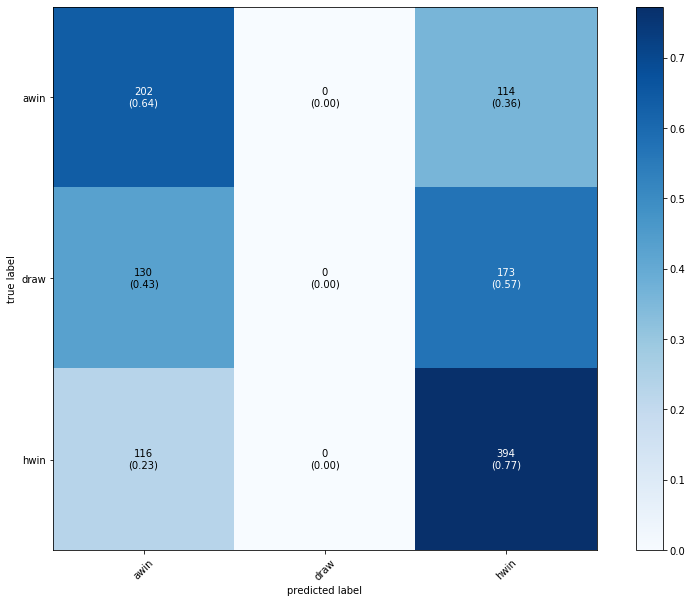

In [24]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=df_cm.values,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                               class_names=cols, figsize=(14,10))
plt.show();

# Other Models

In [25]:
fp = CONSOL_DATA_DIR / 'epl.csv'
df = pd.read_csv(fp, index_col=None)

### Load the Data

In [26]:
PAST_GAMES=8
keeper_cols3, df_all_features = get_n_past_games(df, PAST_GAMES)
# Drop the rows where any of the features have a NaN
df_all_features = df_all_features.dropna(subset=keeper_cols3).reset_index(drop=True)
df_all_features.drop(columns=['h_ftGoals', 'a_ftGoals'], inplace=True)
df_all_features.head()

,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,h_h_ftGoals-6,h_h_ftGoals-7,h_h_ftGoals-8,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_a_ftGoals-7,a_a_ftGoals-8,a_h_ftGoals-1,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,a_h_ftGoals-7,a_h_ftGoals-8,h_a_ftGoals-1,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_a_ftGoals-7,h_a_ftGoals-8,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,h_h_shots-6,h_h_shots-7,h_h_shots-8,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_a_shots-7,a_a_shots-8,a_h_shots-1,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,a_h_shots-7,a_h_shots-8,h_a_shots-1,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_a_shots-7,h_a_shots-8,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,h_h_shotsOnTarget-6,h_h_shotsOnTarget-7,h_h_shotsOnTarget-8,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_a_shotsOnTarget-7,a_a_shotsOnTarget-8,a_h_shotsOnTarget-1,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,a_h_shotsOnTarget-7,a_h_shotsOnTarget-8,h_a_shotsOnTarget-1,h_a_shotsOnTarget-2,h_a_shotsOnTarget-3,h_a_shotsOnTarget-4,h_a_shotsOnTarget-5,h_a_shotsOnTarget-6,h_a_shotsOnTarget-7,h_a_shotsOnTarget-8,h_h_oddsWinMean-1,h_h_oddsWinMean-2,h_h_oddsWinMean-3,h_h_oddsWinMean-4,h_h_oddsWinMean-5,h_h_oddsWinMean-6,h_h_oddsWinMean-7,h_h_oddsWinMean-8,a_a_oddsWinMean-1,a_a_oddsWinMean-2,a_a_oddsWinMean-3,a_a_oddsWinMean-4,a_a_oddsWinMean-5,a_a_oddsWinMean-6,a_a_oddsWinMean-7,a_a_oddsWinMean-8,a_h_oddsWinMean-1,a_h_oddsWinMean-2,a_h_oddsWinMean-3,a_h_oddsWinMean-4,a_h_oddsWinMean-5,a_h_oddsWinMean-6,a_h_oddsWinMean-7,a_h_oddsWinMean-8,h_a_oddsWinMean-1,h_a_oddsWinMean-2,h_a_oddsWinMean-3,h_a_oddsWinMean-4,h_a_oddsWinMean-5,h_a_oddsWinMean-6,h_a_oddsWinMean-7,h_a_oddsWinMean-8,h_h_oddsDrawMean-1,h_h_oddsDrawMean-2,h_h_oddsDrawMean-3,h_h_oddsDrawMean-4,h_h_oddsDrawMean-5,h_h_oddsDrawMean-6,h_h_oddsDrawMean-7,h_h_oddsDrawMean-8,a_a_oddsDrawMean-1,a_a_oddsDrawMean-2,a_a_oddsDrawMean-3,a_a_oddsDrawMean-4,a_a_oddsDrawMean-5,a_a_oddsDrawMean-6,a_a_oddsDrawMean-7,a_a_oddsDrawMean-8,a_h_oddsDrawMean-1,a_h_oddsDrawMean-2,a_h_oddsDrawMean-3,a_h_oddsDrawMean-4,a_h_oddsDrawMean-5,a_h_oddsDrawMean-6,a_h_oddsDrawMean-7,a_h_oddsDrawMean-8,h_a_oddsDrawMean-1,h_a_oddsDrawMean-2,h_a_oddsDrawMean-3,h_a_oddsDrawMean-4,h_a_oddsDrawMean-5,h_a_oddsDrawMean-6,h_a_oddsDrawMean-7,h_a_oddsDrawMean-8,result
0,2.0,2.0,2.0,3.0,5.0,3.0,1.0,2.0,2.0,2.0,2.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0,1.0,6.0,0.0,0.0,1.0,3.0,1.0,1.0,2.0,3.0,1.0,1.0,3.0,1.0,13.0,16.0,19.0,18.0,15.0,10.0,16.0,19.0,9.0,13.0,9.0,15.0,4.0,20.0,6.0,15.0,11.0,14.0,15.0,16.0,16.0,16.0,18.0,19.0,7.0,6.0,14.0,16.0,11.0,16.0,16.0,10.0,6.0,6.0,9.0,8.0,9.0,8.0,10.0,13.0,5.0,7.0,6.0,8.0,1.0,8.0,2.0,7.0,4.0,5.0,10.0,9.0,4.0,8.0,7.0,11.0,4.0,2.0,9.0,7.0,4.0,12.0,10.0,3.0,1.15,2.43,1.23,1.18,1.16,1.50,1.59,1.32,1.25,1.41,1.64,1.70,3.70,1.66,2.88,1.55,1.17,1.28,1.34,1.49,1.31,1.37,1.28,1.19,1.52,1.64,1.93,1.50,2.84,1.79,2.45,2.20,6.41,3.13,5.29,5.92,6.12,3.74,3.61,4.49,5.15,4.05,3.51,3.44,3.17,3.43,3.06,3.61,6.31,4.89,4.37,3.77,4.67,4.23,4.74,5.74,3.65,3.51,3.25,3.80,3.15,3.41,3.17,3.23,hwin
1,1.0,2.0,2.0,2.0,3.0,5.0,3.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,3.0,0.0,2.0,2.0,4.0,1.0,4.0,1.0,4.0,1.0,1.0,1.0,2.0,3.0,1.0,1.0,3.0,1.0,11.0,13.0,16.0,19.0,18.0,15.0,10.0,16.0,12.0,9.0,9.0,11.0,11.0,10.0,13.0,10.0,12.0,17.0,19.0,9.0,19.0,14.0,25.0,14.0,7.0,6.0,14.0,16.0,11.0,16.0,16.0,10.0,5.0,6.0,6.0,9.0,8.0,9.0,8.0,10.0,5.0,5.0,4.0,4.0,6.0,7.0,8.0,3.0,8.0,9.0,8.0,6.0,12.0,5.0,14.0,8.0,4.0,2.0,9.0,7.0,4.0,12.0,10.0,3.0,2.40,1.15,2.43,1.23,1.18,1.16,1.50,1.59,3.27,2.50,2.45,2.90,6.26,2.43,2.23,6.07,2.04,1.42,1.46,2.12,1.94,2.78,1.45,1.82,1.52,1.64,1.93,1.50,2.84,1.79,2.45,2.20,3.06,6.41,3.13,

In [27]:
df_all_features.shape

(2367, 161)

### cut out some of the features


In [28]:
keepers = ['h_h_ftGoals-1', 'a_a_ftGoals-1', 'result']
keepers = df_all_features.columns
df_cut = df_all_features[keepers]

In [29]:
df_cut.head()

,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,h_h_ftGoals-6,h_h_ftGoals-7,h_h_ftGoals-8,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_a_ftGoals-7,a_a_ftGoals-8,a_h_ftGoals-1,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,a_h_ftGoals-7,a_h_ftGoals-8,h_a_ftGoals-1,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_a_ftGoals-7,h_a_ftGoals-8,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,h_h_shots-6,h_h_shots-7,h_h_shots-8,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_a_shots-7,a_a_shots-8,a_h_shots-1,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,a_h_shots-7,a_h_shots-8,h_a_shots-1,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_a_shots-7,h_a_shots-8,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,h_h_shotsOnTarget-6,h_h_shotsOnTarget-7,h_h_shotsOnTarget-8,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_a_shotsOnTarget-7,a_a_shotsOnTarget-8,a_h_shotsOnTarget-1,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,a_h_shotsOnTarget-7,a_h_shotsOnTarget-8,h_a_shotsOnTarget-1,h_a_shotsOnTarget-2,h_a_shotsOnTarget-3,h_a_shotsOnTarget-4,h_a_shotsOnTarget-5,h_a_shotsOnTarget-6,h_a_shotsOnTarget-7,h_a_shotsOnTarget-8,h_h_oddsWinMean-1,h_h_oddsWinMean-2,h_h_oddsWinMean-3,h_h_oddsWinMean-4,h_h_oddsWinMean-5,h_h_oddsWinMean-6,h_h_oddsWinMean-7,h_h_oddsWinMean-8,a_a_oddsWinMean-1,a_a_oddsWinMean-2,a_a_oddsWinMean-3,a_a_oddsWinMean-4,a_a_oddsWinMean-5,a_a_oddsWinMean-6,a_a_oddsWinMean-7,a_a_oddsWinMean-8,a_h_oddsWinMean-1,a_h_oddsWinMean-2,a_h_oddsWinMean-3,a_h_oddsWinMean-4,a_h_oddsWinMean-5,a_h_oddsWinMean-6,a_h_oddsWinMean-7,a_h_oddsWinMean-8,h_a_oddsWinMean-1,h_a_oddsWinMean-2,h_a_oddsWinMean-3,h_a_oddsWinMean-4,h_a_oddsWinMean-5,h_a_oddsWinMean-6,h_a_oddsWinMean-7,h_a_oddsWinMean-8,h_h_oddsDrawMean-1,h_h_oddsDrawMean-2,h_h_oddsDrawMean-3,h_h_oddsDrawMean-4,h_h_oddsDrawMean-5,h_h_oddsDrawMean-6,h_h_oddsDrawMean-7,h_h_oddsDrawMean-8,a_a_oddsDrawMean-1,a_a_oddsDrawMean-2,a_a_oddsDrawMean-3,a_a_oddsDrawMean-4,a_a_oddsDrawMean-5,a_a_oddsDrawMean-6,a_a_oddsDrawMean-7,a_a_oddsDrawMean-8,a_h_oddsDrawMean-1,a_h_oddsDrawMean-2,a_h_oddsDrawMean-3,a_h_oddsDrawMean-4,a_h_oddsDrawMean-5,a_h_oddsDrawMean-6,a_h_oddsDrawMean-7,a_h_oddsDrawMean-8,h_a_oddsDrawMean-1,h_a_oddsDrawMean-2,h_a_oddsDrawMean-3,h_a_oddsDrawMean-4,h_a_oddsDrawMean-5,h_a_oddsDrawMean-6,h_a_oddsDrawMean-7,h_a_oddsDrawMean-8,result
0,2.0,2.0,2.0,3.0,5.0,3.0,1.0,2.0,2.0,2.0,2.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0,1.0,6.0,0.0,0.0,1.0,3.0,1.0,1.0,2.0,3.0,1.0,1.0,3.0,1.0,13.0,16.0,19.0,18.0,15.0,10.0,16.0,19.0,9.0,13.0,9.0,15.0,4.0,20.0,6.0,15.0,11.0,14.0,15.0,16.0,16.0,16.0,18.0,19.0,7.0,6.0,14.0,16.0,11.0,16.0,16.0,10.0,6.0,6.0,9.0,8.0,9.0,8.0,10.0,13.0,5.0,7.0,6.0,8.0,1.0,8.0,2.0,7.0,4.0,5.0,10.0,9.0,4.0,8.0,7.0,11.0,4.0,2.0,9.0,7.0,4.0,12.0,10.0,3.0,1.15,2.43,1.23,1.18,1.16,1.50,1.59,1.32,1.25,1.41,1.64,1.70,3.70,1.66,2.88,1.55,1.17,1.28,1.34,1.49,1.31,1.37,1.28,1.19,1.52,1.64,1.93,1.50,2.84,1.79,2.45,2.20,6.41,3.13,5.29,5.92,6.12,3.74,3.61,4.49,5.15,4.05,3.51,3.44,3.17,3.43,3.06,3.61,6.31,4.89,4.37,3.77,4.67,4.23,4.74,5.74,3.65,3.51,3.25,3.80,3.15,3.41,3.17,3.23,hwin
1,1.0,2.0,2.0,2.0,3.0,5.0,3.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,3.0,0.0,2.0,2.0,4.0,1.0,4.0,1.0,4.0,1.0,1.0,1.0,2.0,3.0,1.0,1.0,3.0,1.0,11.0,13.0,16.0,19.0,18.0,15.0,10.0,16.0,12.0,9.0,9.0,11.0,11.0,10.0,13.0,10.0,12.0,17.0,19.0,9.0,19.0,14.0,25.0,14.0,7.0,6.0,14.0,16.0,11.0,16.0,16.0,10.0,5.0,6.0,6.0,9.0,8.0,9.0,8.0,10.0,5.0,5.0,4.0,4.0,6.0,7.0,8.0,3.0,8.0,9.0,8.0,6.0,12.0,5.0,14.0,8.0,4.0,2.0,9.0,7.0,4.0,12.0,10.0,3.0,2.40,1.15,2.43,1.23,1.18,1.16,1.50,1.59,3.27,2.50,2.45,2.90,6.26,2.43,2.23,6.07,2.04,1.42,1.46,2.12,1.94,2.78,1.45,1.82,1.52,1.64,1.93,1.50,2.84,1.79,2.45,2.20,3.06,6.41,3.13,

In [30]:
df_cut1 = df_cut.copy(deep=True)
X = df_cut1
y = X.pop('result')
X.head()

,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,h_h_ftGoals-6,h_h_ftGoals-7,h_h_ftGoals-8,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_a_ftGoals-7,a_a_ftGoals-8,a_h_ftGoals-1,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,a_h_ftGoals-7,a_h_ftGoals-8,h_a_ftGoals-1,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_a_ftGoals-7,h_a_ftGoals-8,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,h_h_shots-6,h_h_shots-7,h_h_shots-8,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_a_shots-7,a_a_shots-8,a_h_shots-1,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,a_h_shots-7,a_h_shots-8,h_a_shots-1,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_a_shots-7,h_a_shots-8,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,h_h_shotsOnTarget-6,h_h_shotsOnTarget-7,h_h_shotsOnTarget-8,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_a_shotsOnTarget-7,a_a_shotsOnTarget-8,a_h_shotsOnTarget-1,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,a_h_shotsOnTarget-7,a_h_shotsOnTarget-8,h_a_shotsOnTarget-1,h_a_shotsOnTarget-2,h_a_shotsOnTarget-3,h_a_shotsOnTarget-4,h_a_shotsOnTarget-5,h_a_shotsOnTarget-6,h_a_shotsOnTarget-7,h_a_shotsOnTarget-8,h_h_oddsWinMean-1,h_h_oddsWinMean-2,h_h_oddsWinMean-3,h_h_oddsWinMean-4,h_h_oddsWinMean-5,h_h_oddsWinMean-6,h_h_oddsWinMean-7,h_h_oddsWinMean-8,a_a_oddsWinMean-1,a_a_oddsWinMean-2,a_a_oddsWinMean-3,a_a_oddsWinMean-4,a_a_oddsWinMean-5,a_a_oddsWinMean-6,a_a_oddsWinMean-7,a_a_oddsWinMean-8,a_h_oddsWinMean-1,a_h_oddsWinMean-2,a_h_oddsWinMean-3,a_h_oddsWinMean-4,a_h_oddsWinMean-5,a_h_oddsWinMean-6,a_h_oddsWinMean-7,a_h_oddsWinMean-8,h_a_oddsWinMean-1,h_a_oddsWinMean-2,h_a_oddsWinMean-3,h_a_oddsWinMean-4,h_a_oddsWinMean-5,h_a_oddsWinMean-6,h_a_oddsWinMean-7,h_a_oddsWinMean-8,h_h_oddsDrawMean-1,h_h_oddsDrawMean-2,h_h_oddsDrawMean-3,h_h_oddsDrawMean-4,h_h_oddsDrawMean-5,h_h_oddsDrawMean-6,h_h_oddsDrawMean-7,h_h_oddsDrawMean-8,a_a_oddsDrawMean-1,a_a_oddsDrawMean-2,a_a_oddsDrawMean-3,a_a_oddsDrawMean-4,a_a_oddsDrawMean-5,a_a_oddsDrawMean-6,a_a_oddsDrawMean-7,a_a_oddsDrawMean-8,a_h_oddsDrawMean-1,a_h_oddsDrawMean-2,a_h_oddsDrawMean-3,a_h_oddsDrawMean-4,a_h_oddsDrawMean-5,a_h_oddsDrawMean-6,a_h_oddsDrawMean-7,a_h_oddsDrawMean-8,h_a_oddsDrawMean-1,h_a_oddsDrawMean-2,h_a_oddsDrawMean-3,h_a_oddsDrawMean-4,h_a_oddsDrawMean-5,h_a_oddsDrawMean-6,h_a_oddsDrawMean-7,h_a_oddsDrawMean-8
0,2.0,2.0,2.0,3.0,5.0,3.0,1.0,2.0,2.0,2.0,2.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0,1.0,6.0,0.0,0.0,1.0,3.0,1.0,1.0,2.0,3.0,1.0,1.0,3.0,1.0,13.0,16.0,19.0,18.0,15.0,10.0,16.0,19.0,9.0,13.0,9.0,15.0,4.0,20.0,6.0,15.0,11.0,14.0,15.0,16.0,16.0,16.0,18.0,19.0,7.0,6.0,14.0,16.0,11.0,16.0,16.0,10.0,6.0,6.0,9.0,8.0,9.0,8.0,10.0,13.0,5.0,7.0,6.0,8.0,1.0,8.0,2.0,7.0,4.0,5.0,10.0,9.0,4.0,8.0,7.0,11.0,4.0,2.0,9.0,7.0,4.0,12.0,10.0,3.0,1.15,2.43,1.23,1.18,1.16,1.50,1.59,1.32,1.25,1.41,1.64,1.70,3.70,1.66,2.88,1.55,1.17,1.28,1.34,1.49,1.31,1.37,1.28,1.19,1.52,1.64,1.93,1.50,2.84,1.79,2.45,2.20,6.41,3.13,5.29,5.92,6.12,3.74,3.61,4.49,5.15,4.05,3.51,3.44,3.17,3.43,3.06,3.61,6.31,4.89,4.37,3.77,4.67,4.23,4.74,5.74,3.65,3.51,3.25,3.80,3.15,3.41,3.17,3.23
1,1.0,2.0,2.0,2.0,3.0,5.0,3.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,3.0,0.0,2.0,2.0,4.0,1.0,4.0,1.0,4.0,1.0,1.0,1.0,2.0,3.0,1.0,1.0,3.0,1.0,11.0,13.0,16.0,19.0,18.0,15.0,10.0,16.0,12.0,9.0,9.0,11.0,11.0,10.0,13.0,10.0,12.0,17.0,19.0,9.0,19.0,14.0,25.0,14.0,7.0,6.0,14.0,16.0,11.0,16.0,16.0,10.0,5.0,6.0,6.0,9.0,8.0,9.0,8.0,10.0,5.0,5.0,4.0,4.0,6.0,7.0,8.0,3.0,8.0,9.0,8.0,6.0,12.0,5.0,14.0,8.0,4.0,2.0,9.0,7.0,4.0,12.0,10.0,3.0,2.40,1.15,2.43,1.23,1.18,1.16,1.50,1.59,3.27,2.50,2.45,2.90,6.26,2.43,2.23,6.07,2.04,1.42,1.46,2.12,1.94,2.78,1.45,1.82,1.52,1.64,1.93,1.50,2.84,1.79,2.45,2.20,3.06,6.41,3.13,5.29,5.92,6.

In [31]:
y.head()

0    hwin
1    hwin
2    draw
3    hwin
4    draw
Name: result, dtype: object

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [33]:
# df1 = df_cut.copy(deep=True)

# X = df1
# y_str = X.pop('result')
# print(y_str[0:10])

from sklearn.preprocessing import LabelEncoder
from skoot.preprocessing import SelectiveMinMaxScaler
#from sklearn.utils.multiclass import type_of_target
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.pipeline import Pipeline

# label_encoder = LabelEncoder()

# y = label_encoder.fit_transform(y_str)
skf = StratifiedKFold(n_splits=5)
# print(y[0:10])

# # n_games 1140
# # hwin    0.476316
# # draw    0.263158
# # awin    0.260526
# # Name: result, dty

model = GaussianNB(priors=[0.29, 0.26, 0.45])
model = MultinomialNB(class_prior=[0.29, 0.26, 0.45])
model = ComplementNB(class_prior=[0.29, 0.26, 0.45])
# model = LogisticRegression(class_weight='balanced', solver='newton-cg', multi_class='multinomial', max_iter=300 )
# model = SGDClassifier(loss='log', class_weight='balanced')
# model = SVC(probability=True, class_weight='balanced', C=1, gamma='auto', kernel='linear')
#model = DecisionTreeClassifier()
# model = RadiusNeighborsClassifier(radius=5.0)

pipe = Pipeline([('scaler', SelectiveMinMaxScaler()),
                ('model', model)])

# pipe = Pipeline([('model', model)])   


scores = cross_val_score(pipe, X_train, y_train, cv=skf, scoring='balanced_accuracy')

print(scores)
print(np.mean(scores))

[0.46839854 0.49551591 0.46441636 0.45434296 0.45670985]
0.46787672327973695


In [34]:
model.fit(X_train, y_train)
probas = pd.DataFrame(model.predict_proba(X_test), columns=model.classes_)
full_df = pd.concat([X_test.reset_index(drop=True), probas, y_test.reset_index(drop=True)], axis=1)
full_df['pred'] = full_df[model.classes_].idxmax(axis=1)
full_df.head()

,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,h_h_ftGoals-6,h_h_ftGoals-7,h_h_ftGoals-8,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_a_ftGoals-7,a_a_ftGoals-8,a_h_ftGoals-1,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,a_h_ftGoals-7,a_h_ftGoals-8,h_a_ftGoals-1,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_a_ftGoals-7,h_a_ftGoals-8,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,h_h_shots-6,h_h_shots-7,h_h_shots-8,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_a_shots-7,a_a_shots-8,a_h_shots-1,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,a_h_shots-7,a_h_shots-8,h_a_shots-1,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_a_shots-7,h_a_shots-8,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,h_h_shotsOnTarget-6,h_h_shotsOnTarget-7,h_h_shotsOnTarget-8,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_a_shotsOnTarget-7,a_a_shotsOnTarget-8,a_h_shotsOnTarget-1,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,a_h_shotsOnTarget-7,a_h_shotsOnTarget-8,h_a_shotsOnTarget-1,h_a_shotsOnTarget-2,h_a_shotsOnTarget-3,h_a_shotsOnTarget-4,h_a_shotsOnTarget-5,h_a_shotsOnTarget-6,h_a_shotsOnTarget-7,h_a_shotsOnTarget-8,h_h_oddsWinMean-1,h_h_oddsWinMean-2,h_h_oddsWinMean-3,h_h_oddsWinMean-4,h_h_oddsWinMean-5,h_h_oddsWinMean-6,h_h_oddsWinMean-7,h_h_oddsWinMean-8,a_a_oddsWinMean-1,a_a_oddsWinMean-2,a_a_oddsWinMean-3,a_a_oddsWinMean-4,a_a_oddsWinMean-5,a_a_oddsWinMean-6,a_a_oddsWinMean-7,a_a_oddsWinMean-8,a_h_oddsWinMean-1,a_h_oddsWinMean-2,a_h_oddsWinMean-3,a_h_oddsWinMean-4,a_h_oddsWinMean-5,a_h_oddsWinMean-6,a_h_oddsWinMean-7,a_h_oddsWinMean-8,h_a_oddsWinMean-1,h_a_oddsWinMean-2,h_a_oddsWinMean-3,h_a_oddsWinMean-4,h_a_oddsWinMean-5,h_a_oddsWinMean-6,h_a_oddsWinMean-7,h_a_oddsWinMean-8,h_h_oddsDrawMean-1,h_h_oddsDrawMean-2,h_h_oddsDrawMean-3,h_h_oddsDrawMean-4,h_h_oddsDrawMean-5,h_h_oddsDrawMean-6,h_h_oddsDrawMean-7,h_h_oddsDrawMean-8,a_a_oddsDrawMean-1,a_a_oddsDrawMean-2,a_a_oddsDrawMean-3,a_a_oddsDrawMean-4,a_a_oddsDrawMean-5,a_a_oddsDrawMean-6,a_a_oddsDrawMean-7,a_a_oddsDrawMean-8,a_h_oddsDrawMean-1,a_h_oddsDrawMean-2,a_h_oddsDrawMean-3,a_h_oddsDrawMean-4,a_h_oddsDrawMean-5,a_h_oddsDrawMean-6,a_h_oddsDrawMean-7,a_h_oddsDrawMean-8,h_a_oddsDrawMean-1,h_a_oddsDrawMean-2,h_a_oddsDrawMean-3,h_a_oddsDrawMean-4,h_a_oddsDrawMean-5,h_a_oddsDrawMean-6,h_a_oddsDrawMean-7,h_a_oddsDrawMean-8,awin,draw,hwin,result,pred
0,3.0,4.0,5.0,4.0,4.0,3.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,3.0,0.0,6.0,2.0,0.0,3.0,0.0,1.0,0.0,1.0,1.0,1.0,5.0,1.0,3.0,0.0,2.0,3.0,27.0,32.0,28.0,32.0,18.0,13.0,10.0,10.0,6.0,9.0,7.0,10.0,10.0,9.0,12.0,7.0,21.0,17.0,13.0,12.0,15.0,25.0,6.0,9.0,8.0,12.0,21.0,9.0,11.0,12.0,23.0,15.0,7.0,9.0,12.0,10.0,7.0,7.0,5.0,5.0,3.0,2.0,2.0,2.0,4.0,1.0,5.0,2.0,13.0,5.0,4.0,4.0,2.0,2.0,1.0,2.0,4.0,5.0,10.0,4.0,5.0,4.0,7.0,6.0,1.20,1.29,1.26,1.24,1.41,1.21,1.58,2.52,4.33,5.07,14.26,6.80,8.03,8.07,4.72,15.78,2.04,6.31,2.27,6.06,1.83,2.12,2.36,2.34,3.41,4.52,2.88,1.59,2.50,3.18,1.82,1.67,6.83,5.58,5.81,5.93,4.66,6.48,3.82,3.28,3.35,3.53,6.62,3.73,4.37,4.20,3.47,7.53,3.32,3.90,3.15,3.79,3.39,3.28,3.26,3.20,3.39,3.82,3.33,3.79,3.27,3.35,3.65,3.71,1.155879e-11,1.282177e-08,1.000000e+00,hwin,hwin
1,3.0,2.0,1.0,0.0,0.0,0.0,2.0,1.0,3.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,2.0,2.0,0.0,2.0,0.0,5.0,1.0,10.0,17.0,12.0,22.0,17.0,21.0,9.0,12.0,10.0,10.0,2.0,13.0,10.0,11.0,11.0,4.0,7.0,9.0,17.0,11.0,10.0,6.0,4.0,13.0,10.0,12.0,12.0,5.0,7.0,14.0,8.0,22.0,5.0,9.0,6.0,14.0,5.0,9.0,4.0,8.0,5.0,5.0,0.0,7.0,5.0,9.0,8.0,2.0,4.0,6.0,9.0,7.0,5.0,2.0,2.0,4.0,4.0,7.0,8.0,2.0,4.0,6.0,5.0,9.0,2.04,1.77,2.53,1.77,2.53,2.04,3.02,2.03,3.61,3.30,14.28,3.00,3.33,4.80,3.62,8.06,2.43,1.77,2.02,2.89,1.85,2.93,2.48,1.64,9.

In [35]:
full_df.tail()

,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,h_h_ftGoals-6,h_h_ftGoals-7,h_h_ftGoals-8,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_a_ftGoals-7,a_a_ftGoals-8,a_h_ftGoals-1,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,a_h_ftGoals-7,a_h_ftGoals-8,h_a_ftGoals-1,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_a_ftGoals-7,h_a_ftGoals-8,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,h_h_shots-6,h_h_shots-7,h_h_shots-8,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_a_shots-7,a_a_shots-8,a_h_shots-1,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,a_h_shots-7,a_h_shots-8,h_a_shots-1,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_a_shots-7,h_a_shots-8,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,h_h_shotsOnTarget-6,h_h_shotsOnTarget-7,h_h_shotsOnTarget-8,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_a_shotsOnTarget-7,a_a_shotsOnTarget-8,a_h_shotsOnTarget-1,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,a_h_shotsOnTarget-7,a_h_shotsOnTarget-8,h_a_shotsOnTarget-1,h_a_shotsOnTarget-2,h_a_shotsOnTarget-3,h_a_shotsOnTarget-4,h_a_shotsOnTarget-5,h_a_shotsOnTarget-6,h_a_shotsOnTarget-7,h_a_shotsOnTarget-8,h_h_oddsWinMean-1,h_h_oddsWinMean-2,h_h_oddsWinMean-3,h_h_oddsWinMean-4,h_h_oddsWinMean-5,h_h_oddsWinMean-6,h_h_oddsWinMean-7,h_h_oddsWinMean-8,a_a_oddsWinMean-1,a_a_oddsWinMean-2,a_a_oddsWinMean-3,a_a_oddsWinMean-4,a_a_oddsWinMean-5,a_a_oddsWinMean-6,a_a_oddsWinMean-7,a_a_oddsWinMean-8,a_h_oddsWinMean-1,a_h_oddsWinMean-2,a_h_oddsWinMean-3,a_h_oddsWinMean-4,a_h_oddsWinMean-5,a_h_oddsWinMean-6,a_h_oddsWinMean-7,a_h_oddsWinMean-8,h_a_oddsWinMean-1,h_a_oddsWinMean-2,h_a_oddsWinMean-3,h_a_oddsWinMean-4,h_a_oddsWinMean-5,h_a_oddsWinMean-6,h_a_oddsWinMean-7,h_a_oddsWinMean-8,h_h_oddsDrawMean-1,h_h_oddsDrawMean-2,h_h_oddsDrawMean-3,h_h_oddsDrawMean-4,h_h_oddsDrawMean-5,h_h_oddsDrawMean-6,h_h_oddsDrawMean-7,h_h_oddsDrawMean-8,a_a_oddsDrawMean-1,a_a_oddsDrawMean-2,a_a_oddsDrawMean-3,a_a_oddsDrawMean-4,a_a_oddsDrawMean-5,a_a_oddsDrawMean-6,a_a_oddsDrawMean-7,a_a_oddsDrawMean-8,a_h_oddsDrawMean-1,a_h_oddsDrawMean-2,a_h_oddsDrawMean-3,a_h_oddsDrawMean-4,a_h_oddsDrawMean-5,a_h_oddsDrawMean-6,a_h_oddsDrawMean-7,a_h_oddsDrawMean-8,h_a_oddsDrawMean-1,h_a_oddsDrawMean-2,h_a_oddsDrawMean-3,h_a_oddsDrawMean-4,h_a_oddsDrawMean-5,h_a_oddsDrawMean-6,h_a_oddsDrawMean-7,h_a_oddsDrawMean-8,awin,draw,hwin,result,pred
469,2.0,5.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,3.0,3.0,0.0,2.0,0.0,1.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,2.0,0.0,2.0,1.0,2.0,0.0,21.0,21.0,20.0,12.0,16.0,23.0,12.0,20.0,17.0,10.0,13.0,11.0,12.0,10.0,17.0,9.0,19.0,9.0,23.0,17.0,10.0,10.0,16.0,7.0,12.0,10.0,10.0,16.0,14.0,17.0,8.0,12.0,13.0,13.0,11.0,6.0,7.0,17.0,7.0,12.0,12.0,3.0,8.0,5.0,9.0,4.0,11.0,4.0,8.0,5.0,15.0,11.0,2.0,4.0,8.0,3.0,8.0,7.0,8.0,7.0,9.0,10.0,6.0,8.0,1.47,2.46,1.28,2.81,1.26,1.22,1.55,1.45,2.96,2.57,3.57,2.82,11.78,4.13,2.85,3.25,2.46,5.27,1.79,2.40,1.82,4.80,4.06,5.16,2.34,3.74,2.08,1.68,1.77,1.94,1.75,5.07,4.14,3.36,5.33,3.29,5.47,6.02,3.89,4.19,3.30,3.25,3.31,3.24,5.28,3.40,3.27,3.28,3.24,3.65,3.46,3.24,3.39,3.57,3.38,3.60,3.29,3.41,3.37,3.70,3.51,3.41,3.57,3.68,1.214985e-06,1.432374e-05,9.999845e-01,hwin,hwin
470,1.0,0.0,3.0,4.0,2.0,0.0,1.0,1.0,2.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,2.0,1.0,3.0,2.0,3.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,3.0,12.0,11.0,13.0,15.0,6.0,11.0,3.0,8.0,10.0,12.0,9.0,16.0,17.0,24.0,12.0,15.0,8.0,12.0,17.0,4.0,19.0,15.0,21.0,18.0,7.0,5.0,13.0,8.0,6.0,2.0,11.0,10.0,3.0,7.0,4.0,11.0,5.0,4.0,2.0,4.0,4.0,8.0,5.0,11.0,9.0,20.0,4.0,9.0,4.0,6.0,14.0,3.0,11.0,11.0,10.0,11.0,2.0,1.0,9.0,5.0,2.0,0.0,5.0,7.0,2.50,2.55,2.94,1.83,7.83,3.21,7.73,2.09,6.01,3.39,3.17,4.09,7.78,3.24,3.43,3.65,2.31,5.20,3.04,4.67,1.8

In [36]:
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(full_df['result'], full_df['pred']))
df_cm

,0,1,2
0,98,3,32
1,55,2,52
2,71,5,156


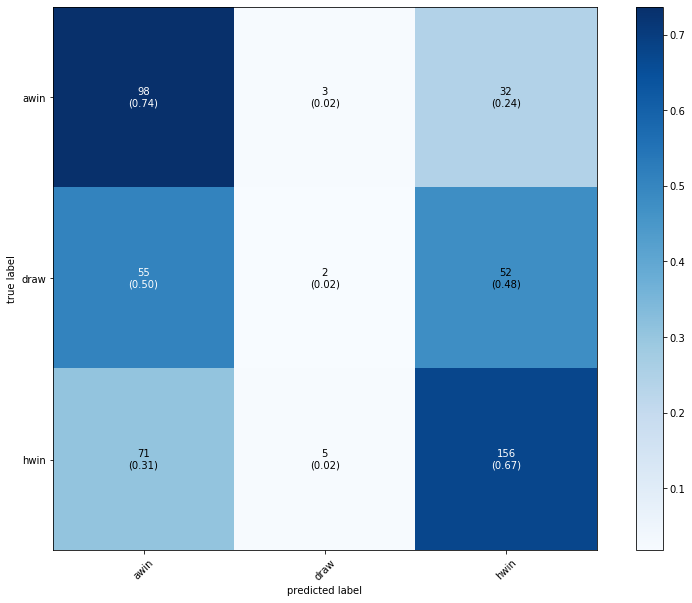

In [37]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=df_cm.values,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                               class_names=model.classes_, figsize=(14,10))
plt.show();